In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Df: [ 1.  2.  4.  8. 16. 32. 64.]
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433


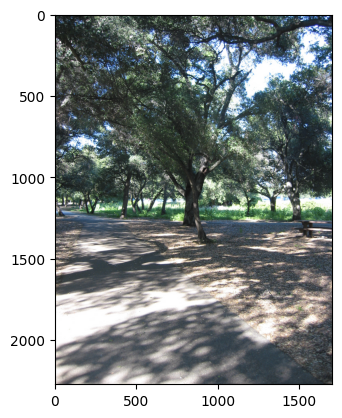

(2272, 1704, 3)


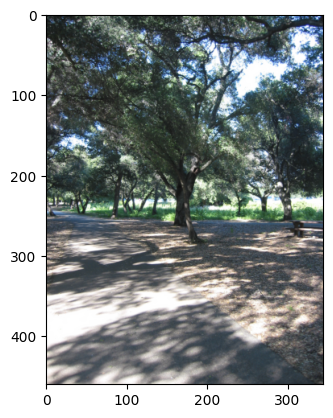

Pixel size (m/pix): 1.5456521739130434e-05


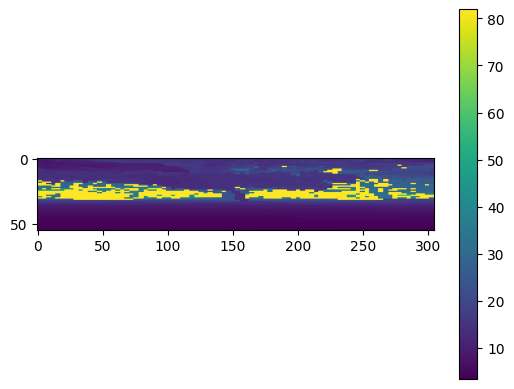

GT DPT Range: 3.3600285 - 81.921196


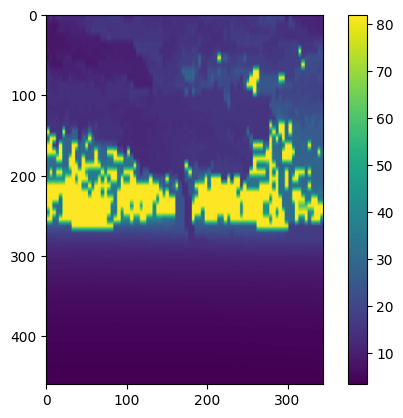

adaptive kernel size set to 17


In [2]:
globals.init_Make3D()

IMAGE_RANGE = 255.
gt_aif, gt_dpt = utils.load_single_sample_Make3D(img_name = "img-math7-p-282t0.jpg", data_dir = "/data/holly_jackson/")
gt_aif = gt_aif * IMAGE_RANGE


gt_dpt_resized = skimage.transform.resize(
    gt_dpt,
    output_shape=(460, 345), # (height, width)
    order=1,                  # bilinear interpolation
    anti_aliasing=True,
    preserve_range=True       # keep values in [0, 255] if original was uint8
)

plt.imshow(gt_dpt_resized)
plt.colorbar()
plt.show()

width, height, _ = gt_aif.shape
max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

globals.thresh = 0.5


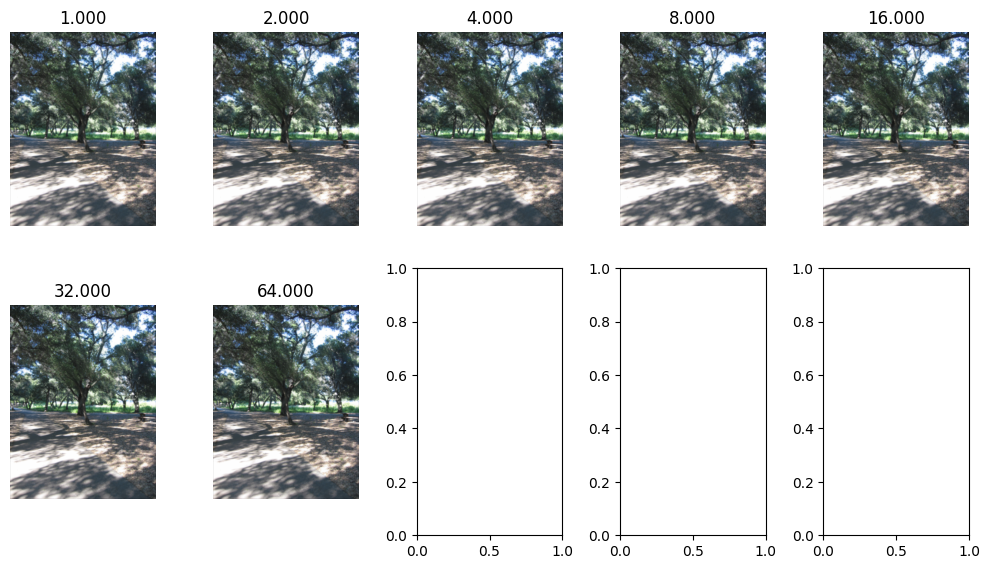

In [3]:
# forward model (torch)
# FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt_resized, gt_aif)
# defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)


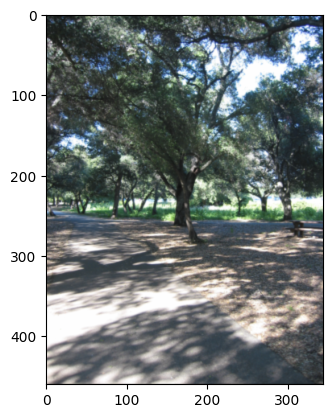

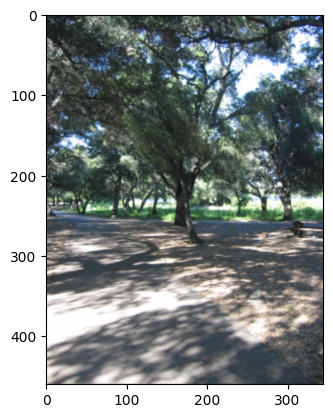

In [4]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=False, save_plots=True,
        experiment_name = 'make3d', num_epochs = 40,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 500, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = globals.min_Z, max_Z = globals.max_Z,
        vmin = globals.min_Z, vmax = globals.max_Z, verbose = True,
        windowed_mse = False)


Created experiment folder: /data/holly_jackson/experiments/make3d_2025-10-28_23-38-59
Images in range [0-255]
Iteration 0 



Grid search         : 100%|███████████████████| 500/500 [02:34<00:00,  3.24it/s]


GRID SEARCH DURATION 155.94195175170898

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 248.72421216964722
Loss: 10.295745 , TV: 161413.06

DPT result range: [ 0.013412195 , 79.97215 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 200/200 [32:33<00:00,  9.77s/it]


r1norm 1201.6967 norm(x) 86089.46
FISTA duration 2031.3445086479187

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.43336734 , TV: 15360081.0
FULL ITER DURATION 2464.0683164596558
ls_maxiter updated to 210


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 500/500 [02:34<00:00,  3.23it/s]


GRID SEARCH DURATION 157.26297879219055

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 279.3766715526581
Loss: 0.22317581 , TV: 1525058.2

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 210/210 [35:46<00:00, 10.22s/it]


r1norm 782.959 norm(x) 86150.51
FISTA duration 2225.567575931549

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.18397668 , TV: 15805707.0
FULL ITER DURATION 2691.0105862617493
ls_maxiter updated to 220


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 500/500 [02:34<00:00,  3.24it/s]


GRID SEARCH DURATION 156.69376707077026

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 279.53880739212036
Loss: 0.17677762 , TV: 1939819.5

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 220/220 [37:59<00:00, 10.36s/it]


r1norm 759.39453 norm(x) 86187.32
FISTA duration 2359.2040071487427

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.17307124 , TV: 16050422.0
FULL ITER DURATION 2823.966749191284
ls_maxiter updated to 231


--------------------------

Iteration 3 



Grid search         : 100%|███████████████████| 500/500 [02:32<00:00,  3.28it/s]


GRID SEARCH DURATION 154.61122798919678

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 279.03792786598206
Loss: 0.17133182 , TV: 1976992.0

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 231/231 [39:56<00:00, 10.37s/it]


r1norm 751.6609 norm(x) 86219.67
FISTA duration 2475.5445013046265

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16956356 , TV: 16251393.0
FULL ITER DURATION 2937.709211587906
ls_maxiter updated to 242


--------------------------

Iteration 4 



Grid search         : 100%|███████████████████| 500/500 [02:33<00:00,  3.25it/s]


GRID SEARCH DURATION 155.8171844482422

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 279.226886510849
Loss: 0.16862251 , TV: 2006093.9

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 242/242 [41:47<00:00, 10.36s/it]


r1norm 746.42194 norm(x) 86250.35
FISTA duration 2587.1370766162872

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1672079 , TV: 16429143.0
FULL ITER DURATION 3050.6560337543488
ls_maxiter updated to 254


--------------------------

Iteration 5 



Grid search         : 100%|███████████████████| 500/500 [02:33<00:00,  3.26it/s]


GRID SEARCH DURATION 155.73174500465393

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.18133521080017
Loss: 0.16657607 , TV: 2024629.4

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 254/254 [43:48<00:00, 10.35s/it]


r1norm 742.32367 norm(x) 86279.73
FISTA duration 2707.290769100189

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16537665 , TV: 16590889.0
FULL ITER DURATION 3168.646171808243
ls_maxiter updated to 266


--------------------------

Iteration 6 



Grid search         : 100%|███████████████████| 500/500 [02:33<00:00,  3.25it/s]


GRID SEARCH DURATION 156.11520099639893

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.17382431030273
Loss: 0.16489843 , TV: 2041546.2

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 266/266 [45:52<00:00, 10.35s/it]


r1norm 739.65015 norm(x) 86306.54
FISTA duration 2831.7796676158905

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16418748 , TV: 16734484.0
FULL ITER DURATION 3293.273410797119
ls_maxiter updated to 279


--------------------------

Iteration 7 



Grid search         : 100%|███████████████████| 500/500 [02:30<00:00,  3.32it/s]


GRID SEARCH DURATION 152.9554340839386

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 275.6396174430847
Loss: 0.16387083 , TV: 2057329.5

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 279/279 [47:59<00:00, 10.32s/it]


r1norm 737.708 norm(x) 86331.91
FISTA duration 2958.214238882065

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16332619 , TV: 16868122.0
FULL ITER DURATION 3414.888592004776
ls_maxiter updated to 292


--------------------------

Iteration 8 



Grid search         : 100%|███████████████████| 500/500 [02:27<00:00,  3.39it/s]


GRID SEARCH DURATION 149.67909145355225

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.7951281070709
Loss: 0.16292278 , TV: 2069541.0

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 292/292 [50:16<00:00, 10.33s/it]


r1norm 734.956 norm(x) 86355.18
FISTA duration 3095.5892012119293

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16210943 , TV: 16989724.0
FULL ITER DURATION 3551.382222175598
ls_maxiter updated to 306


--------------------------

Iteration 9 



Grid search         : 100%|███████████████████| 500/500 [02:27<00:00,  3.39it/s]


GRID SEARCH DURATION 149.7465419769287

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.7007486820221
Loss: 0.16189942 , TV: 2076245.1

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 306/306 [52:39<00:00, 10.33s/it]


r1norm 733.49915 norm(x) 86377.59
FISTA duration 3238.4724996089935

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16146746 , TV: 17104034.0
FULL ITER DURATION 3694.241367340088
ls_maxiter updated to 321


--------------------------

Iteration 10 



Grid search         : 100%|███████████████████| 500/500 [02:27<00:00,  3.39it/s]


GRID SEARCH DURATION 149.55904006958008

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.3194818496704
Loss: 0.16128452 , TV: 2080340.4

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 321/321 [55:16<00:00, 10.33s/it]


r1norm 732.16064 norm(x) 86398.27
FISTA duration 3395.293957710266

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16087836 , TV: 17212328.0
FULL ITER DURATION 3850.4191727638245
ls_maxiter updated to 337


--------------------------

Iteration 11 



Grid search         : 100%|███████████████████| 500/500 [02:27<00:00,  3.39it/s]


GRID SEARCH DURATION 149.73868942260742

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 277.94752168655396
Loss: 0.16074003 , TV: 2083451.1

DPT result range: [ 0.013412195 , 79.99553 ]


Bounded FISTA...


Optimizing: 100%|██████████████████| 337/337 [58:04<00:00, 10.34s/it]


r1norm 731.11993 norm(x) 86417.28
FISTA duration 3563.586433172226

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16042158 , TV: 17310596.0
FULL ITER DURATION 4019.5477528572083
ls_maxiter updated to 353


--------------------------

Iteration 12 



Grid search         : 100%|███████████████████| 500/500 [02:27<00:00,  3.39it/s]


GRID SEARCH DURATION 149.5872242450714

Golden-section search...
...searching for 100 % convergence


In [ ]:
print('RMS', utils.compute_RMS(dpt, gt_dpt_resized))
print('Rel', utils.compute_Rel(dpt, gt_dpt_resized))
print(utils.compute_accuracy_metrics(dpt, gt_dpt_resized))

utils.plot_compare_greyscale(dpt, gt_dpt_resized, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

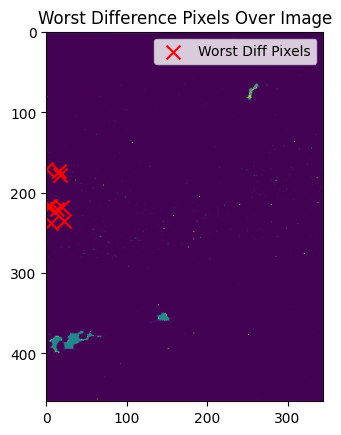

In [9]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt_resized, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt_resized)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [10]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

Grid search         : 100%|███████████████████| 100/100 [00:30<00:00,  3.32it/s]


(460, 345, 1)


In [12]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

[ 1.  2.  4.  8. 16. 32. 64.] 0.0025334821428571433 0.00709375
[[[0.00179193 0.00179457 0.00179588 0.00179653 0.00179686 0.00179702
   0.00179711]]]
[[[57.96668  58.05207  58.09454  58.115715 58.126286 58.13157  58.134212]]]


In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

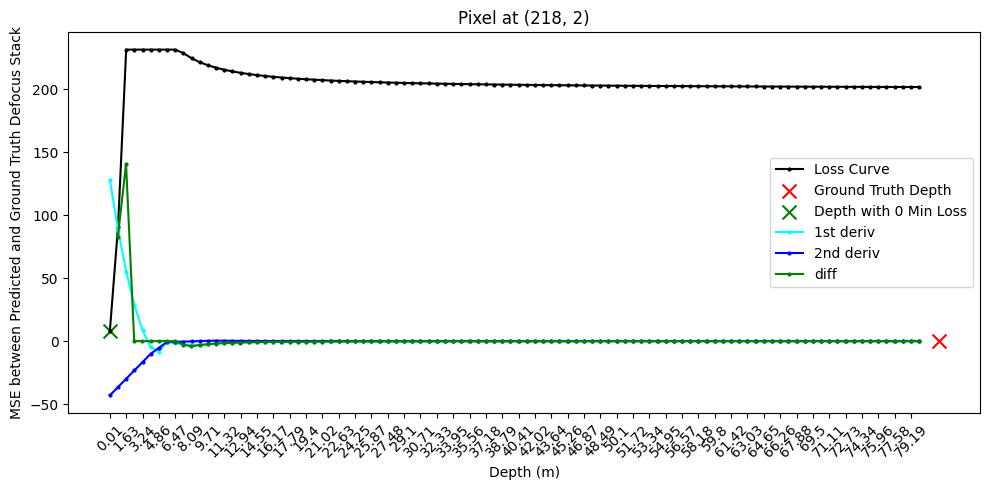

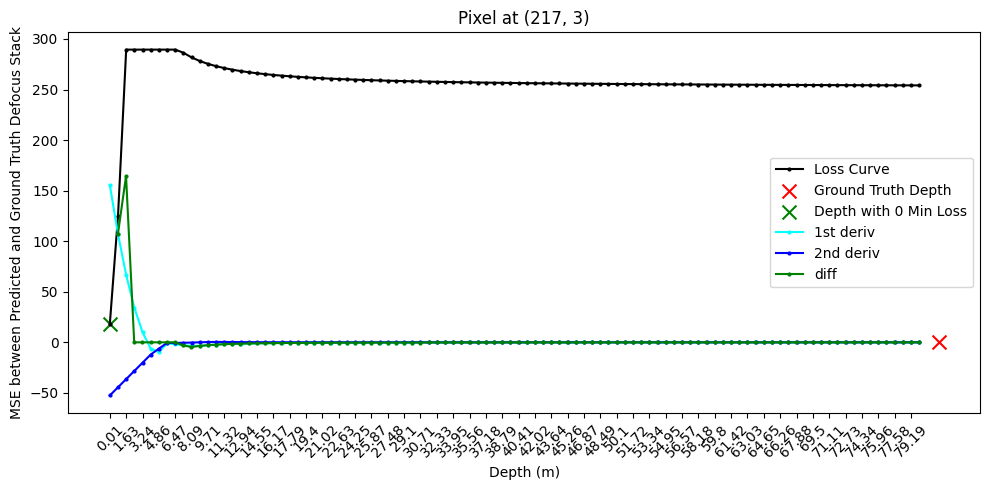

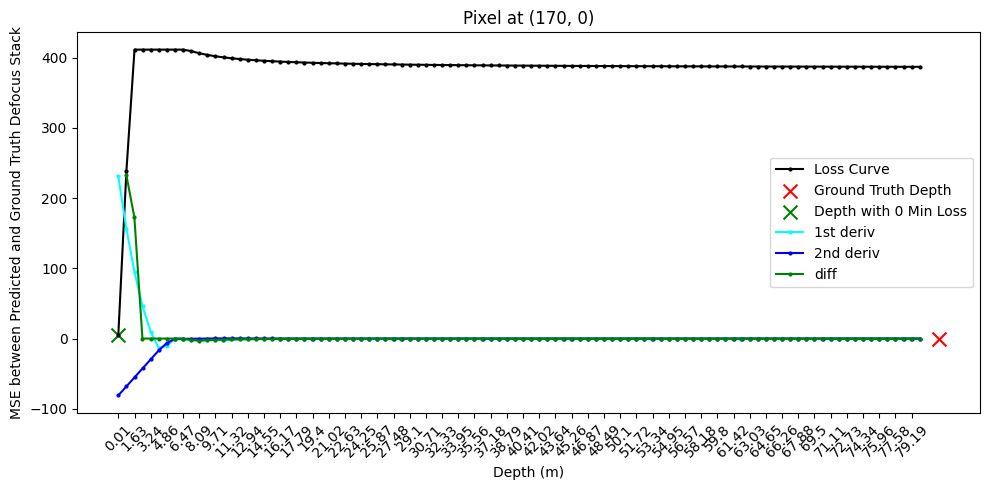

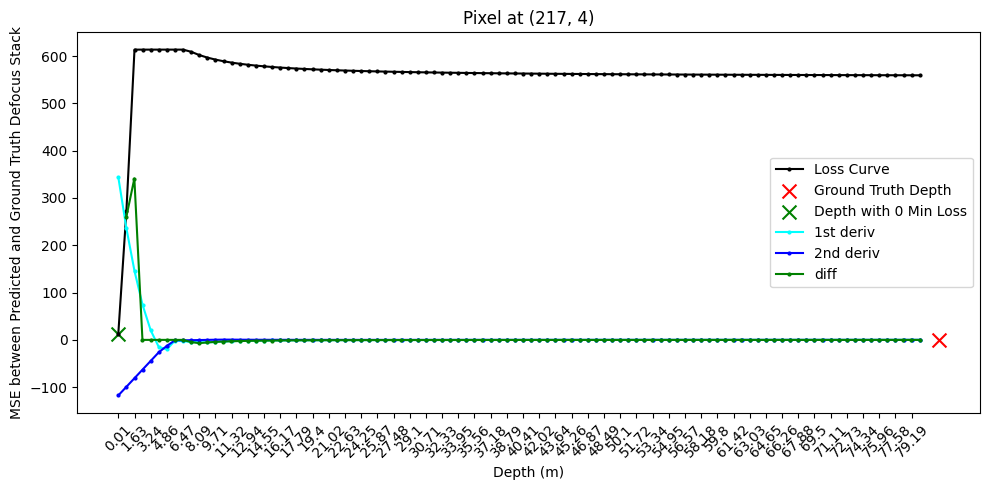

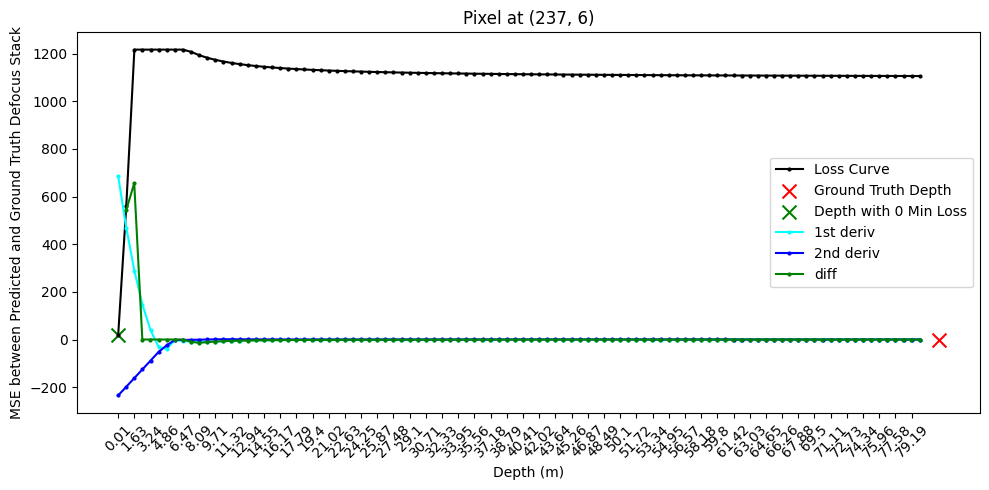

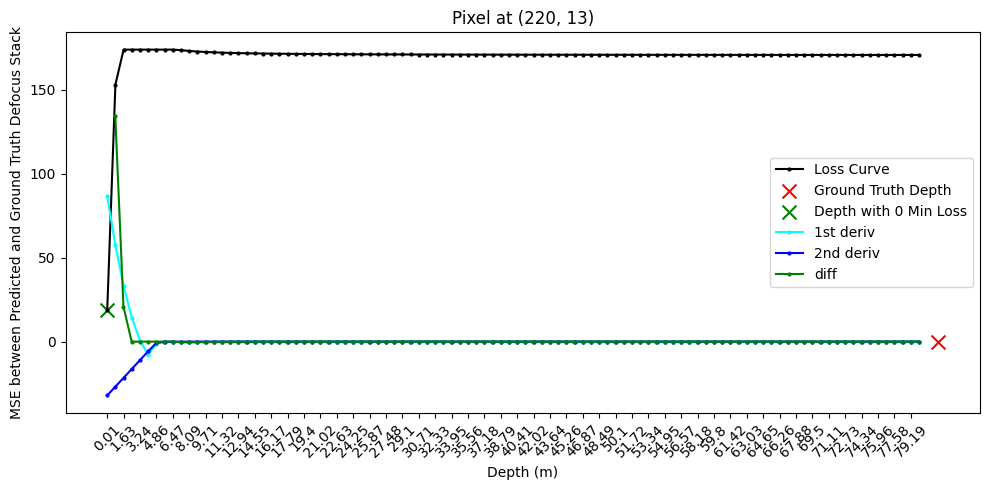

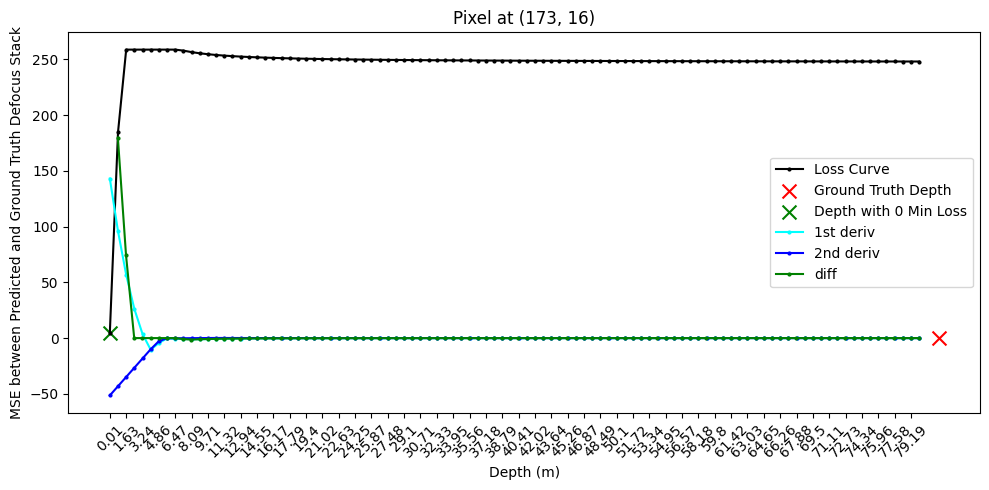

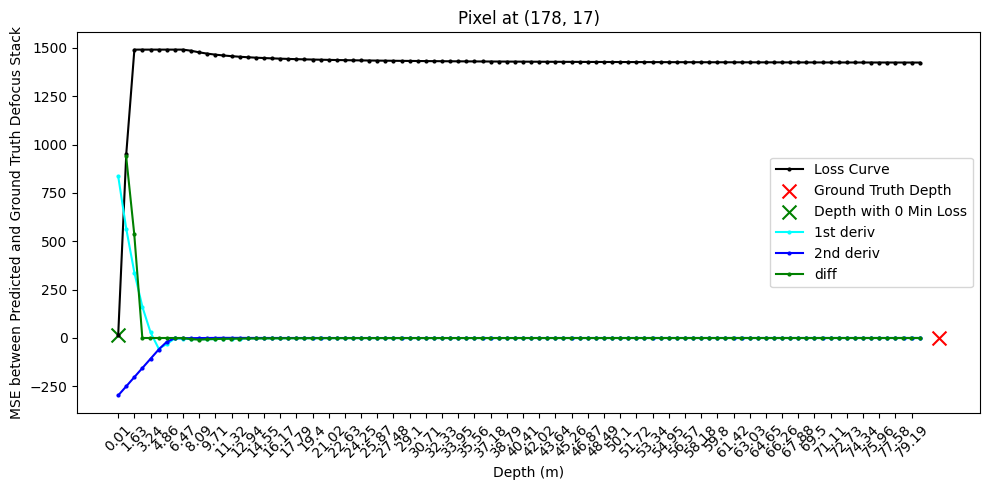

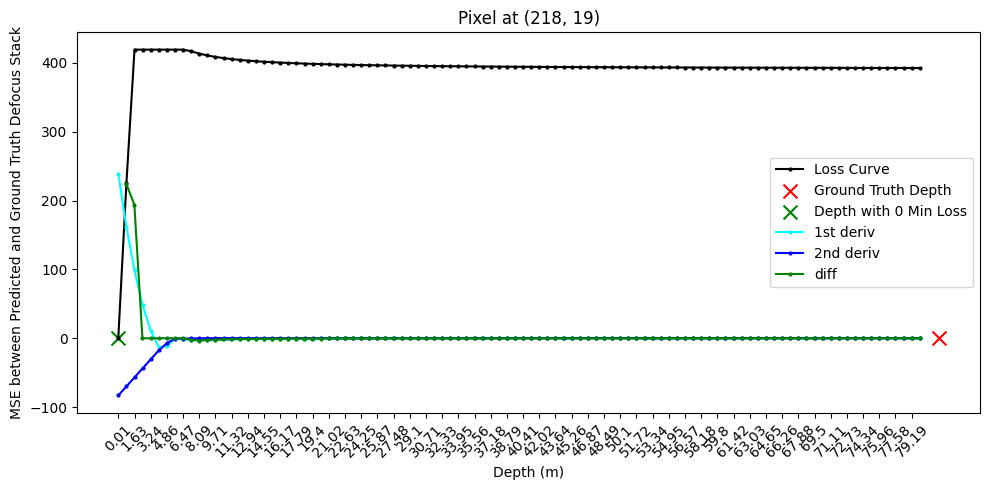

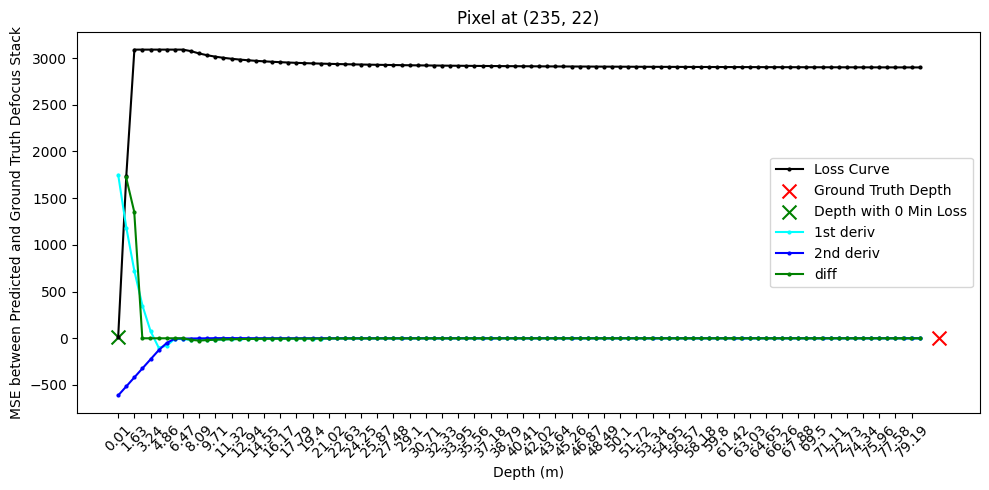

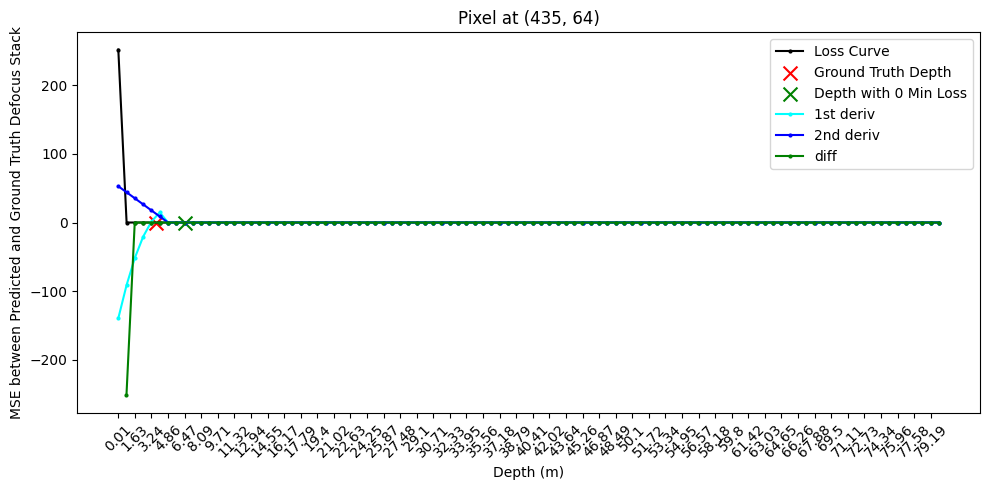

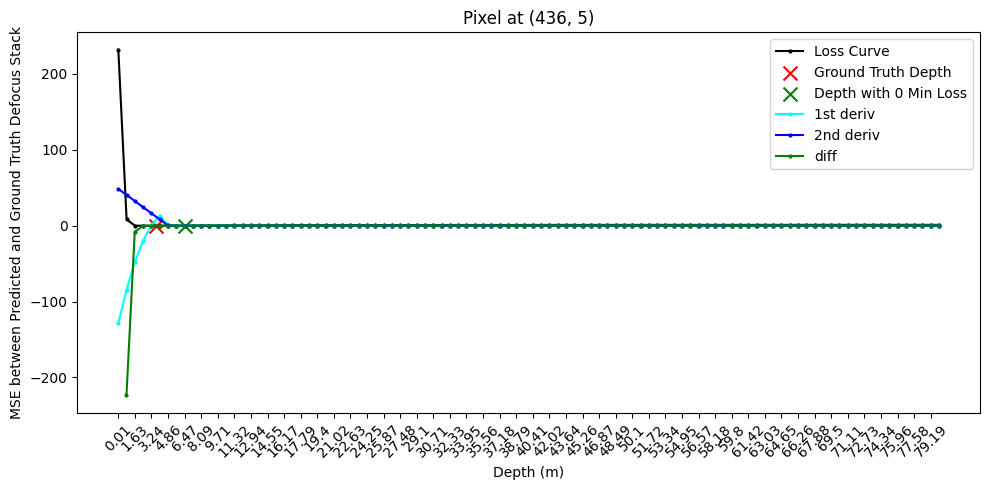

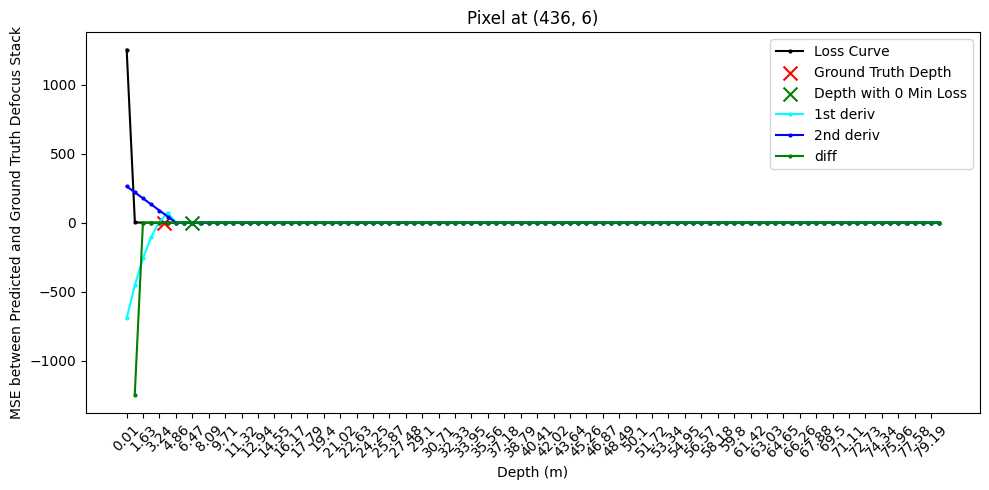

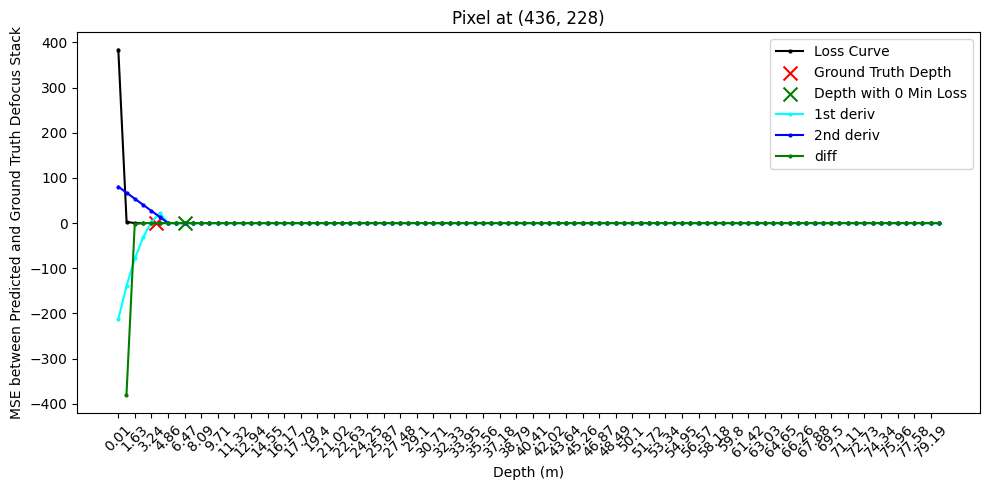

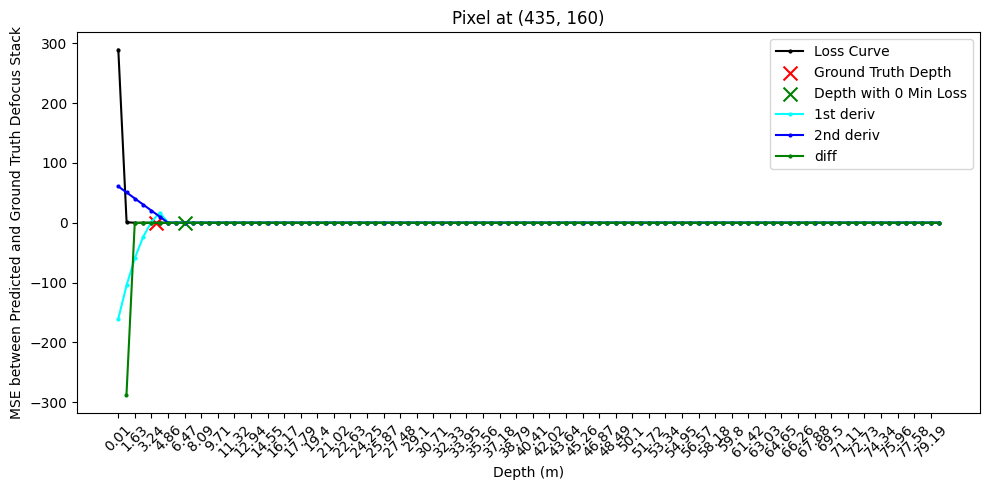

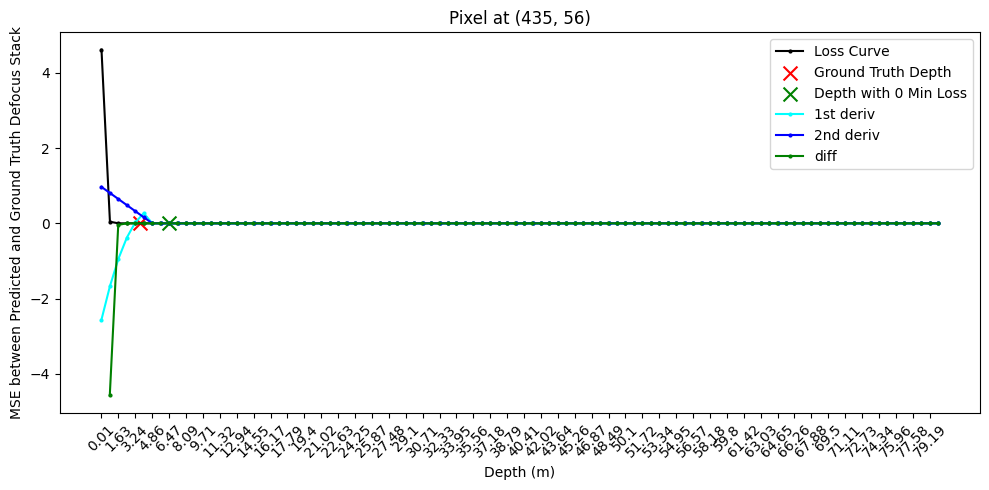

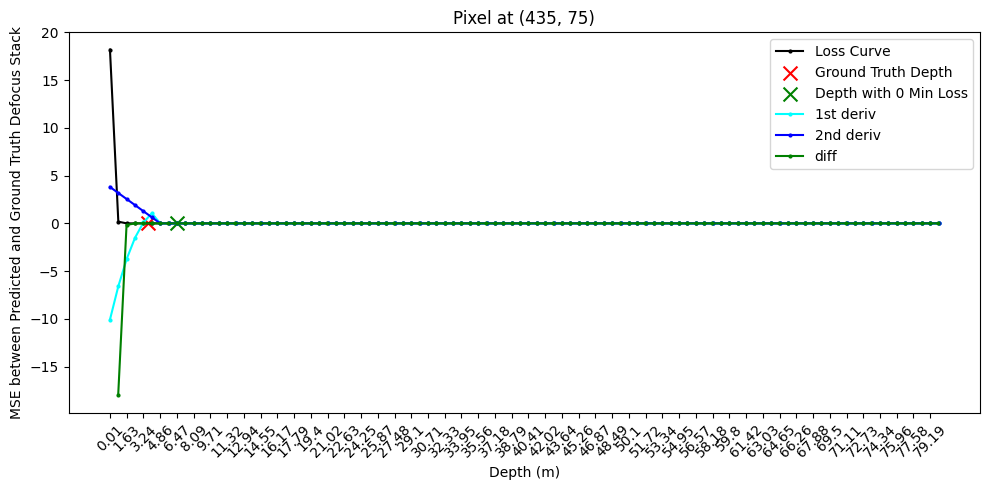

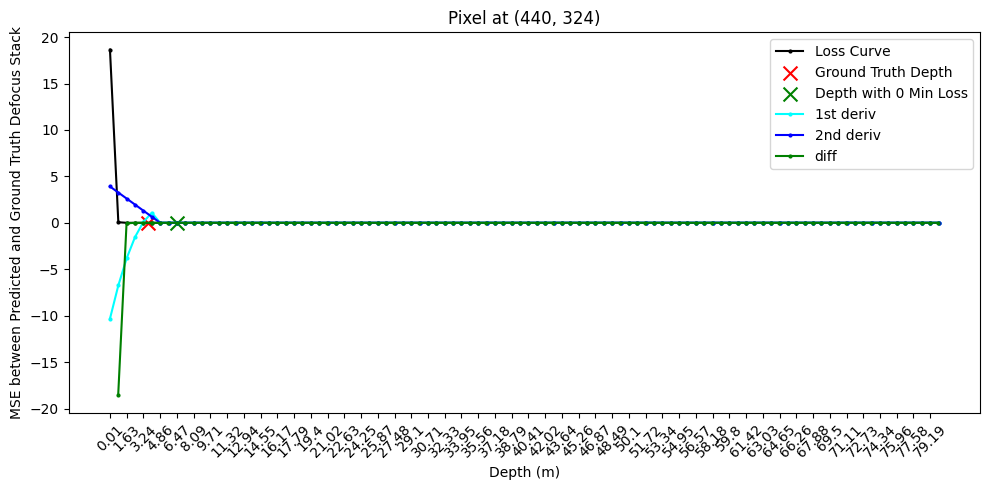

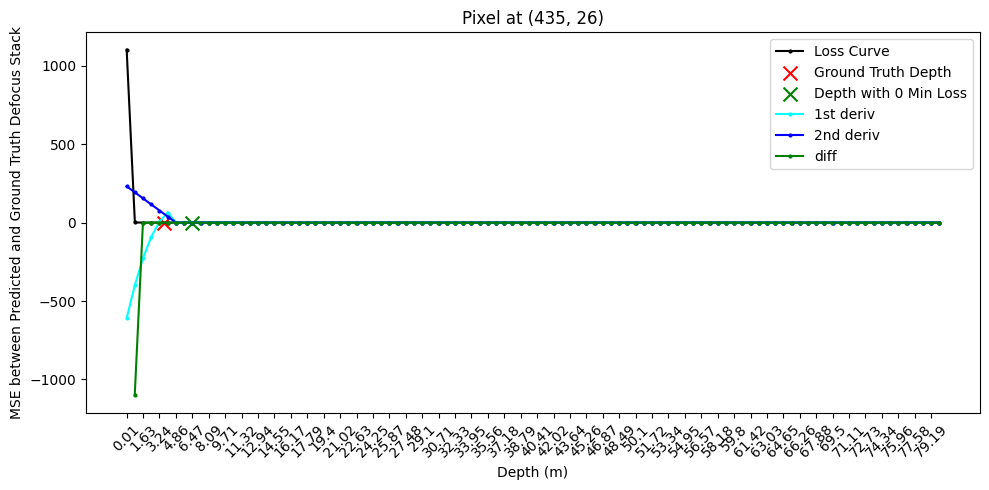

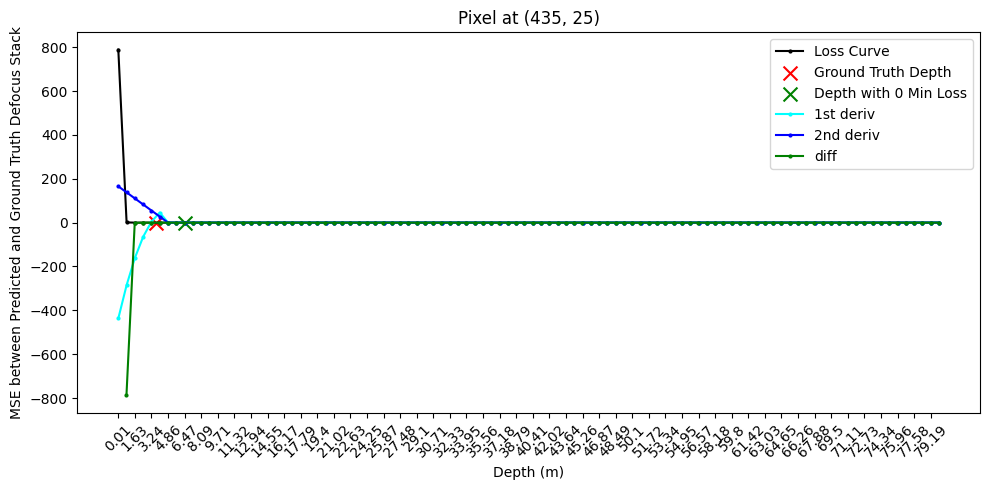

In [11]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt_resized,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt_resized,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])